In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, scale
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [2]:
data = pd.read_csv('data/train.csv')

In [3]:
def preproc(data, dict_grade=None,dict_sub_grade=None, dict_pymnt_plan=None, dict_purpose=None, list_verification_status= None):
    
    data = data.drop([ 'issue_d', 'earliest_cr_line',  'zip_code', 'addr_state', 'record_id','policy_code'], axis=1)
    
    data['term'] = data['term'].map({' 36 months': 0, ' 60 months': 1})    
    data['initial_list_status'] = data['initial_list_status'].map({'f': 0, 'w': 1})
    data['application_type'] = data['application_type'].map({'INDIVIDUAL': 0, 'JOINT': 1})
    data['emp_length'] = data['emp_length'].map({'< 1 year': 1, '1 year': 2, '2 years': 3,  '3 years': 4,  '4 years': 5,  '5 years': 6,  '6 years': 7,  '7 years': 8,  '8 years': 9,  '9 years': 10,  '10+ years': 11})

    data.emp_length.fillna(value=0,inplace=True)
    data.revol_util.fillna(value=0,inplace=True)  
    data['emp_title'] = data.emp_title.map(lambda x: 0 if x == 'n/a' else 1)

    data.collections_12_mths_ex_med.fillna(value=data.collections_12_mths_ex_med.mean(),inplace=True)
    data.mths_since_last_delinq.fillna(value=data.mths_since_last_delinq.mean(),inplace=True)
    data.tot_coll_amt.fillna(value=data.tot_coll_amt.mean(),inplace=True)
    data.tot_cur_bal.fillna(value=data.tot_coll_amt.mean(),inplace=True)
    data.total_rev_hi_lim.fillna(value=data.total_rev_hi_lim.mean(),inplace=True)   
    

    #ohe = OneHotEncoder(sparse=False)    
    #import pandas as pd
    #data = pd.concat([data.drop('home_ownership', 1),pd.DataFrame(ohe.fit_transform(data['home_ownership'].values.reshape(-1, 1)))], axis=1)
    
    #new_ohe_features = ohe.fit(data.home_ownership.values.reshape(-1, 1))
    #encode = ohe.transform(data.home_ownership.values.reshape(-1, 1))
    #print(new_ohe_features)
    
    #new_ohe_features = ohe.fit(data.verification_status.values.reshape(-1, 1))
    #data['verification_status_ohe'] = ohe.transform(data.verification_status.values.reshape(-1, 1))
    verification_status_list = data.verification_status.values.reshape(-1, 1)
    data = pd.concat((data,pd.get_dummies(data.verification_status)),1)
   
    if list_verification_status is None:
        list_verification_status = list(data['verification_status'].unique())
 
    for i in list_verification_status:
        try:
            data[i]
        except KeyError:
            data[i] = 0    
    
    le = LabelEncoder()

    if dict_grade is None:
        le.fit(data.grade.astype(str))
        data['grade_le'] = le.transform((data['grade'].values))
        dict_grade = dict(zip(le.classes_, le.transform(le.classes_)))
    else:
        data['grade_le'] = data['grade'].map(dict_grade).fillna(-1)  

    if dict_sub_grade is None:
        le.fit(data.sub_grade.astype(str))
        data['sub_grade_le'] = le.transform(data['sub_grade'].values)
        dict_sub_grade = dict(zip(le.classes_, le.transform(le.classes_)))
    else:
        data['sub_grade_le'] = data['sub_grade'].map(dict_sub_grade).fillna(-1)           

    if dict_pymnt_plan is None:
        le.fit(data.pymnt_plan.astype(str))
        data['pymnt_plan_le'] = le.transform(data['pymnt_plan'].values)
        dict_pymnt_plan = dict(zip(le.classes_, le.transform(le.classes_)))
    else:
        data['pymnt_plan_le'] = data['pymnt_plan'].map(dict_pymnt_plan).fillna(0)
        
    if dict_purpose is None:
        le.fit(data.purpose.astype(str))
        data['purpose_le'] = le.transform(data['purpose'].values)
        dict_purpose = dict(zip(le.classes_, le.transform(le.classes_)))

    else:
        data['purpose_le'] = data['purpose'].map(dict_purpose).fillna(-1)  
    data = data.drop(['grade', 'sub_grade', 'purpose', 'pymnt_plan', 'home_ownership', 'verification_status'], axis=1)   
    return data, dict_grade, dict_sub_grade, dict_pymnt_plan, dict_purpose, list_verification_status

In [4]:
train, test = train_test_split(data, test_size=0.3, random_state=42)

In [5]:
train, dict_grade, dict_sub_grade, dict_pymnt_plan, dict_purpose, list_verification_status = preproc(train)
test = preproc(test, dict_grade, dict_sub_grade, dict_pymnt_plan, dict_purpose, list_verification_status)[0]

In [6]:
x_train = train.drop(['loan_status'], axis=1)

In [7]:
x_train = train.drop(['loan_status'], axis=1)
y_train = train['loan_status']

x_test = test.drop(['loan_status'], axis=1)
y_test = test['loan_status']

In [8]:
train_cl = pd.DataFrame()
train_cl['grade_le'] =  train['sub_grade_le'] 

train_cl['dti'] = train['dti']
train_cl['int_rate'] = train['int_rate']


In [9]:
test_cl = pd.DataFrame()
test_cl['grade_le'] =  test['sub_grade_le'] 

test_cl['dti'] = test['dti']
test_cl['int_rate'] = test['int_rate']

In [10]:
train_cl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 3 columns):
grade_le    140132 non-null int32
dti         140132 non-null float64
int_rate    140132 non-null float64
dtypes: float64(2), int32(1)
memory usage: 3.7 MB


In [11]:
from sklearn import preprocessing
train_cl_st = preprocessing.scale(train_cl)
train_cl_st = pd.DataFrame(train_cl)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by the scale function.
  


In [12]:
from sklearn import preprocessing
test_cl_st = preprocessing.scale(test_cl)
test_cl_st = pd.DataFrame(test_cl)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


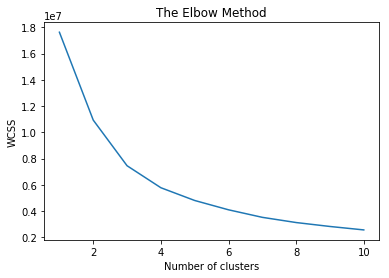

In [13]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(train_cl_st)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [14]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(train_cl_st)

y_kmeans1=y_kmeans


cluster = pd.DataFrame(y_kmeans1)

train['K-means'] = cluster

kmeans_mean_cluster = pd.DataFrame(round(train.groupby('K-means').mean(),1))
kmeans_mean_cluster

,loan_amnt,term,int_rate,installment,emp_title,emp_length,annual_inc,loan_status,dti,delinq_2yrs,...,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,Not Verified,Source Verified,Verified,grade_le,sub_grade_le,pymnt_plan_le,purpose_le
K-means,,,,,,,,,,,,,,,,,,,,,
0.0,13720.2,0.2,13.9,422.3,1.0,6.6,72397.6,0.8,16.7,0.3,...,154.0,104756.8,29464.1,0.3,0.3,0.4,1.8,11.2,0.0,2.9
1.0,13646.3,0.2,13.9,420.5,1.0,6.5,72642.5,0.8,16.6,0.3,...,171.0,103587.0,29668.9,0.3,0.3,0.4,1.8,11.2,0.0,2.8
2.0,13645.2,0.2,13.9,419.7,1.0,6.5,71892.2,0.8,16.7,0.3,...,172.4,103602.5,29530.0,0.3,0.3,0.4,1.8,11.1,0.0,2.8


In [15]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(test_cl_st)

y_kmeans1=y_kmeans


cluster = pd.DataFrame(y_kmeans1)

test['K-means'] = cluster

kmeans_mean_cluster = pd.DataFrame(round(test.groupby('K-means').mean(),1))
kmeans_mean_cluster

,loan_amnt,term,int_rate,installment,emp_title,emp_length,annual_inc,loan_status,dti,delinq_2yrs,...,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,Not Verified,Source Verified,Verified,grade_le,sub_grade_le,pymnt_plan_le,purpose_le
K-means,,,,,,,,,,,,,,,,,,,,,
0.0,13517.4,0.2,13.9,416.6,1.0,6.5,71871.6,0.8,16.7,0.3,...,140.4,104492.9,29236.3,0.3,0.3,0.4,1.8,11.1,0.0,2.9
1.0,13617.7,0.2,13.9,419.5,1.0,6.6,72323.4,0.8,16.7,0.3,...,175.1,105578.4,28604.6,0.3,0.3,0.4,1.8,11.2,0.0,2.8
2.0,13743.6,0.2,13.8,424.1,1.0,6.5,72962.3,0.8,16.7,0.2,...,172.9,105301.7,29137.2,0.3,0.3,0.4,1.8,11.1,0.0,2.8


In [16]:
print(train[train['K-means'] == 0].shape)
train_cl0 = train[train['K-means'] == 0]

(25014, 32)


In [17]:
print(test[test['K-means'] == 0].shape)
test_cl0 = test[test['K-means'] == 0]

(5822, 32)


In [18]:
train_cl0_x = train_cl0.drop(['loan_status'], axis=1)
train_cl0_y = train_cl0['loan_status']
test_cl0_x = test_cl0.drop(['loan_status'], axis=1)
test_cl0_y = test_cl0['loan_status']

In [19]:
import xgboost as xgb

cls_0 = xgb.XGBClassifier()
cls_0.fit(train_cl0_x, train_cl0_y)
preds0 = cls_0.predict(test_cl0_x)
print('XGB: ')
print('Accuracy score: ' + str(metrics.accuracy_score(test_cl0_y, preds0)))

print('Recall score: ' + str(metrics.recall_score(test_cl0_y, preds0)))

print('Precision score: ' + str(metrics.precision_score(test_cl0_y, preds0)))
preds_p0 = cls_0.predict_proba(test_cl0_x)
preds_p0 = preds_p0[:,1]
fpr, tpr, _ = metrics.roc_curve(test_cl0_y, preds_p0)

XGB: 
Accuracy score: 0.778941944349021
Recall score: 0.9799116997792494
Precision score: 0.7877551020408163


In [20]:
print(train[train['K-means'] == 1].shape)
train_cl1 = train[train['K-means'] == 1]

(31898, 32)


In [21]:
print(test[test['K-means'] == 0].shape)
test_cl1 = test[test['K-means'] == 0]

(5822, 32)


In [22]:
train_cl1_x = train_cl1.drop(['loan_status'], axis=1)
train_cl1_y = train_cl1['loan_status']
test_cl1_x = test_cl1.drop(['loan_status'], axis=1)
test_cl1_y = test_cl1['loan_status']

In [23]:
cls_1 = xgb.XGBClassifier()
cls_1.fit(train_cl1_x, train_cl1_y)
preds1 = cls_1.predict(test_cl1_x)
print('XGB: ')
print('Accuracy score: ' + str(metrics.accuracy_score(test_cl1_y, preds1)))

print('Recall score: ' + str(metrics.recall_score(test_cl1_y, preds1)))

print('Precision score: ' + str(metrics.precision_score(test_cl1_y, preds1)))
preds_p1 = cls_1.predict_proba(test_cl1_x)
preds_p1 = preds_p1[:,1]
fpr, tpr, _ = metrics.roc_curve(test_cl1_y, preds_p1)

XGB: 
Accuracy score: 0.7794572311920303
Recall score: 0.9814569536423841
Precision score: 0.7874601487778958


In [24]:
print(train[train['K-means'] == 2].shape)
train_cl2 = train[train['K-means'] == 2]

(41432, 32)


In [25]:
print(test[test['K-means'] == 2].shape)
test_cl2 = test[test['K-means'] == 2]

(4620, 32)


In [26]:
train_cl2_x = train_cl2.drop(['loan_status'], axis=1)
train_cl2_y = train_cl2['loan_status']
test_cl2_x = test_cl2.drop(['loan_status'], axis=1)
test_cl2_y = test_cl2['loan_status']

In [27]:
cls_2 = xgb.XGBClassifier()
cls_2.fit(train_cl2_x, train_cl2_y)
preds2 = cls_2.predict(test_cl2_x)
print('XGB: ')
print('Accuracy score: ' + str(metrics.accuracy_score(test_cl2_y, preds2)))

print('Recall score: ' + str(metrics.recall_score(test_cl2_y, preds2)))

print('Precision score: ' + str(metrics.precision_score(test_cl2_y, preds2)))
preds_p2 = cls_2.predict_proba(test_cl2_x)
preds_p2 = preds_p2[:,1]
fpr, tpr, _ = metrics.roc_curve(test_cl2_y, preds_p2)

XGB: 
Accuracy score: 0.7893939393939394
Recall score: 0.9805585980284776
Precision score: 0.7987954494757975


In [28]:
preds = np.append(preds_p0, preds_p1)
preds = np.append(preds, preds_p2)

test_cl_y = np.append(test_cl0_y, test_cl1_y)
test_cl_y = np.append(test_cl_y, test_cl2_y)

fpr, tpr, _ = metrics.roc_curve(test_cl_y, preds)
print('Auc score: ' + str(metrics.auc(fpr, tpr)))

Auc score: 0.6978582209687662
